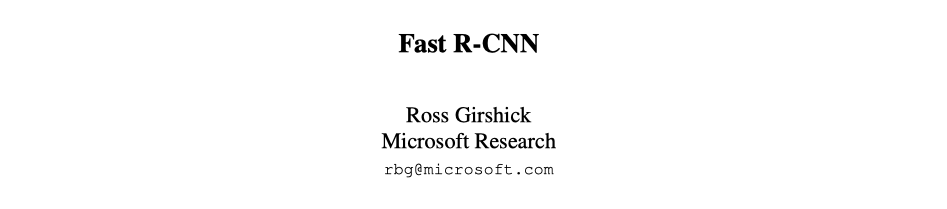

> Girshick R. Fast r-cnn[C]//Proceedings of the IEEE international conference on computer vision. 2015: 1440-1448.

# 论文概述

2014年`R-CNN`横空出世，首次将卷积神经网络带入目标检测领域。受SPPnet启发，作者Ross Girshick在15年发表`Fast R-CNN`，它的构思精巧，流程更为紧凑，大幅提高目标检测速度。同样使用VGG16作为网络的backbone，Fast R-CNN和R-CNN相比，训练时间从84小时减少为9.5小时，测试时间从47秒减少为0.32秒,即训练时间快9倍，测试推理时间快213倍。在PASCAL VOC 2007上的准确率相差无几，约在66%-67%之间。

本文的主要贡献在于：
- `Fast R-CNN`具有更高的目标检测的精度
- 训练过程采用多任务的损失函数
- 训练可以更新所有网络层的参数
- 不需要额外的磁盘空间存储特征

<img src="../images/ObjectDetection/3-1.jpg" width=500>

## 算法步骤

1. 一张图像生成1K~2K个**候选区域**（使用Selective Search方法） 
    
    同`R-CNN`. 利用`Selective Search`, 算法通过图像分割的方法得到一些原始区域，然后使用一些合并策略如颜色,纹理,相似度等指标,将这些区域合并，得到一个**层次化的区域结构**，而这些结构就包含着可能需要的物体。

2. 将**图像输入网络**得到相应的特征图，将SS算法生成的**候选框投影到特征图上获得相应的特征矩阵**
    > `R-CNN`依次**将全部候选框区域输入卷积神经网络**得到特征需要完成2K次正向传播. 
    >
    > 由于一张图像内候选框之间存在大量重叠，提取特征操作冗余.
    
    `Fast-RCNN`将整张图像送入网络，紧接着从特征图像上提取相应的候选区域。这些候选区域的特征不需要再重复计算。
    <img src="../images/ObjectDetection/3-3.png" width=500>
 
    **在训练阶段, 仅使用其中的一小部分候选区域.**并且对训练数据采样分为正样本和负样本.作者从两千个候选区域中随机采集64个样本.**正样本指有与GT的loU>=0.5的样本, 负样本指有与GT的0.1<loU<0.5的背景样本**. 
    
    这里设置为0.1作为阈值的原因是，作者认为与GT有一定交叠的背景更可能是比较困难的负样本，这样选择负样本有助于收敛和提高准确性，但不难发现，这种选取方法忽略了一些重要的及困难的背景区域。


3. 将每个特征矩阵通过`ROI pooling`层缩放到7x7大小的特征图，接着将特征图展平通过一系列全连接层得到预测结果
<img src="../images/ObjectDetection/3-4.png">

> **边界框回归器**
> 输出对应N+1个类别的候选边界框回归参数($d_x,d_y,d_w,d_h$), 共(N+1)x4个节点
>
> $$
\begin{aligned}
&\hat{G}_x=P_w d_x(P)+P_x \\
&\hat{G}_y=P_h d_y(P)+P_y \\
&\hat{G}_w=P_w \exp \left(d_w(P)\right) \\
&\hat{G}_h=P_h \exp \left(d_h(P)\right)
\end{aligned}
$$
>
> $P_x, P_y, P_w, P_h$ 分别为候选框的中心 $x,y$ 坐标, 以及宽高.
>
> $\hat{G}_x, \hat{G}_y, \hat{G}_w, \hat{G}_n$ 分别为最终预测的边界框中心 $x,y$坐标, 以及宽高.

## 多任务损失

> **Multi-task loss**
> $$
L\left(p, u, t^u, v\right)=L_{c l s}(p, u)+\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)
$$
> 
>
>
> - $p$ 是分类器预测的 softmax概率分布 $p=\left(p_0, \ldots, p_k\right)$
> - $u$ 对应目标真实类别标签
> - $t^u$ 对应边界框回归器预测的对应类别
> - $u$ 的回归参数 $\left(t_x^u, t_y^u, t_w^u, t_h^u\right)$
> - $v$ 对应真实目标的边界框回归参数 $\left(v_x, v_y, v_w, v_h\right)$
> > $$
\begin{aligned}
&v_x=\left(G_x-P_x\right) / P_w \\
&v_y=\left(G_y-P_y\right) / P_h \\
&v_w=\log \left(G_w / P_w\right)  \\
&v_h=\log \left(G_h / P_h\right)
\end{aligned}
$$

1. 分类损失:使用`Cross Entropy Loss交叉熵损失`
$$L_{c l s}(p, u)=-logp_u$$


> - 针对多分类问题 (softmax输出, 所有输出概率和为1)
$$
H=-\sum_i o_i^* \log \left(o_i\right)
$$
>- 针对二分类问题（sigmoid输出, 每个输出节点之间互不相干)
$$
H=-\frac{1}{N} \sum_{i=1}^N\left[o_i^* \log o_i+\left(1-o_i^*\right) \log \left(1-o_i\right)\right]
$$
其中 $o_i^*$ 为真实标签值, $o_i$ 为预测值, 默认 $\log$ 以 为底等于 $\ln$

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
$$\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)$$

\begin{aligned}
&L_{\text {loc }}\left(t^u, v\right)=\sum_{i \in\{x, y, w, h\}} \operatorname{smooth}_{L_1}\left(t_i^u-v_i\right) \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}

> - $[u \geq 1]$是艾弗森括号.当$u \geq 1$时该项等于1,当$u ＜ 1$时该项等于0,即边界框框选的是背景,不计算边界框回归损失.
> 
>
> - 令$\text { smooth }_{L_1}(x)=f$, 则$$L_{\text {loc }}\left(t^u, v\right) = f·(t_x^u-v_x)+f·(t_y^u-v_y)+f·(t_w^u-v_w)+f·(t_h^u-v_h)$$
>
> - Smooth 𝐿1 能从两个方面限制梯度
>  - 当预测框与GT差别过大时，梯度值不至于过大；
>  - 当预测框与GT差别很小时，梯度值足够小。

## 算法评价

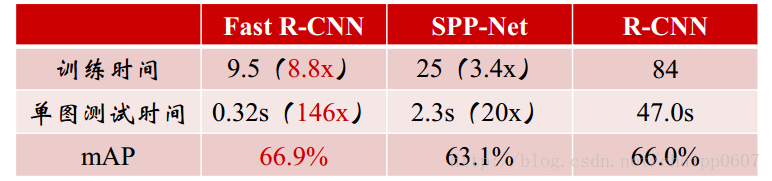

### 算法劣势

`Fast R-CNN`存在的问题：存在瓶颈：选择性搜索，找出所有的候选框，这个也非常耗时。那我们能不能找出一个更加高效的方法来求出这些候选框呢？


解决：加入一个提取Proposal的神经网络，也就说提取候选框的工作也交给神经网络来做了。
做这样的任务的神经网络叫做`Region Proposal Network`(RPN网络)。

# 论文精读

## 摘要

<img src="../images/ObjectDetection/3-11.png" width=500>

## 引言

作者首先回顾了`R-CNN` 和 `SPPnet`,指出来两种网络的缺点:`R-CNN`的训练是多阶段管道任务结果,且在时间和空间上代价很大,而目标检测结果速度很慢.`R-CNN`速度很慢主要归咎于模型需要对每个候选区域执行CNN前向传播.

而空间金字塔池网络`SPPnets`被提出来通过共享计算来加速`R-CNN`,主要区别是在最后一个全连接层之前将`最大池化层`更改为`空间金字塔池化层`,但是该模型提出的微调算法不能更新空间金字塔池化层之前的卷积层。这种将限制了非常深的网络的准确性。

> **SPPNet**:在空间金字塔池化层生成三个不同尺度的特征矩阵.
> 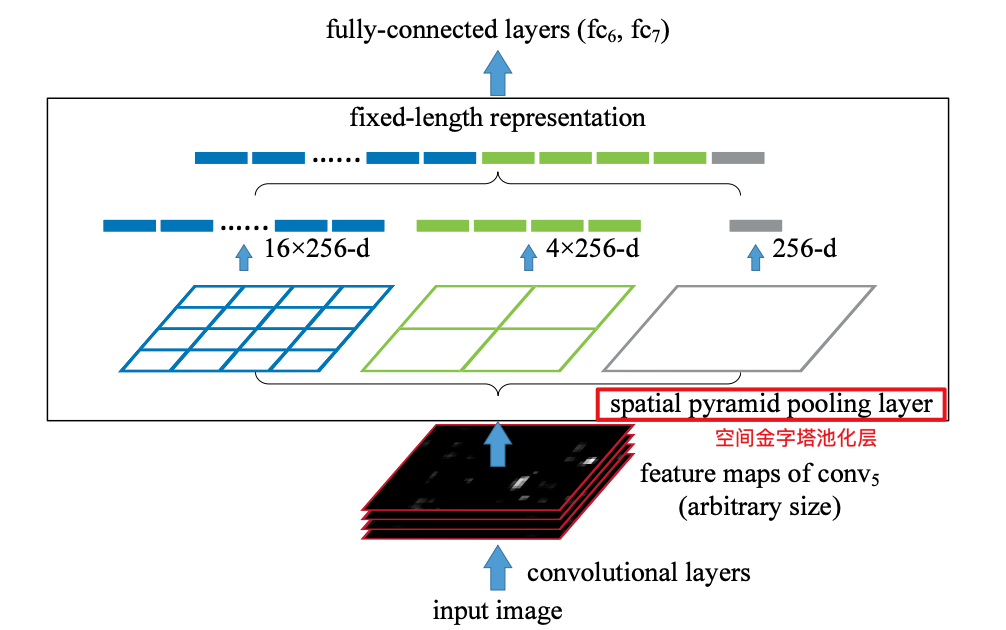

本文的主要贡献在于：
- `Fast R-CNN`具有更高的目标检测的精度
- 训练过程采用多任务的损失函数
- 训练可以更新所有网络层的参数
- 不需要额外的磁盘空间存储特征

## Fast R-CNN 架构与训练

<img src="../images/ObjectDetection/3-1.jpg" width=500>

整体架构:`Fast R-CNN` 网络将整个图像和一组候选区域作为输入。网络首先用几个卷积和最大池化层处理整个图像，以产生一个卷积特征图。然后，将候选框投影到特征图上获得相应的特征矩阵, 将每个特征矩阵通过ROI pooling层缩放到固定长度大小的特征图。接着将特征图展平, 每个特征向量被输入到一个全连接层中, 最终分支成两个并行的输出层的层：一个产生`softmax`概率估计的层(ķ个对象类加上背景类), 另一个为每个对象输出对应N+1个类别的候选边界框回归参数.

### ROI 池化层

ROI 层只是 `SPPnets` 中使用的空间金字塔池化层的特例. 每个ROI由一个四元组定义$(r，c，h，w)$定其**左上角**$(r，c)$及其高度和宽度$(h，w)$.每个ROI被汇集成一个固定大小的特征图.`Fast R-CNN`网络中每个 ROI 有两个输出向量：softmax 概率和每类边界框回归偏移量.

具体操作是对特征矩阵7×7等分，对等分以后的每一区城进行maxpooling 不限制输入图像的尺寸，都将输入7×7等分.

###  从预训练网络初始化

网络首先使用在ImageNet上进行预训练,预训练网络到`Fast R-CNN` 需要三个转换.
1. 将最后一个最大池化层替换为配置好的 RoI 池化层.其中 $H$和$W$与网络的第一个全连接层兼容（例如，$H= W= 7$对于 `VGG16`）.
2. 将网络的最后一个全连接层和 softmax层 替换为两个并行的全连接层(分别用于目标分类预测,边界框参数预测)
3. 修改网络以获取两个数据输入：图像列表和这些图像中的候选区域列表。

### 微调模型

使用反向传播训练所有网络权重是 `Fast R-CNN` 的一项重要能力。首先，作者阐明了为什么` SPPnet `无法更新空间金字塔池化层之前层的权重:每个 候选区域可能有一个非常大的感受野，通常跨越整个输入图像。由于前向传递必须处理整个感受野，因此训练输入很大, 占有大量的显存, 导致了反向传播效率低下.

作者提出了一种更有效的训练方法: **该方法在训练期间利用特征共享**。在 `Fast R-CNN `训练中，**随机梯度下降SGD的 mini-batch 采用分层采样**，首先通过采样n张图像，然后从每个图像通过$R / N$($R$:ROI个数, $N$:采样图片个数)的比例进行采样。至关重要的是，来自同一图像的 ROI 在前向和后向传递中共享计算和内存.作者使用N= 2和R = 128的策略.

#### 多任务损失

`Fast R-CNN`网络中有两个并行的输出层：一个产生`softmax`概率估计的层(ķ个对象类加上背景类), 另一个为每个对象输出对应N+1个类别的候选边界框回归参数.


> $$
L\left(p, u, t^u, v\right)={\color{Blue}{L_{c l s}(p, u)}}+{\color{red}{\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)}}
$$
> 
>
>
 - $p$ 是分类器预测的 softmax概率分布 $p=\left(p_0, \ldots, p_k\right)$
 - $u$ 对应目标真实类别GT标签
 - $t^u$ 对应边界框回归器预测的对应类别
 - $u$ 的回归参数 $\left(t_x^u, t_y^u, t_w^u, t_h^u\right)$
 - $v$ 对应真实目标GT的边界框回归参数 $\left(v_x, v_y, v_w, v_h\right)$

>  \begin{aligned}
&v_x=\left(G_x-P_x\right) / P_w \\
&v_y=\left(G_y-P_y\right) / P_h \\
&v_w=\log \left(G_w / P_w\right)  \\
&v_h=\log \left(G_h / P_h\right)
\end{aligned}

1. 分类损失:使用`Cross Entropy Loss交叉熵损失`
>$${\color{Blue}{L_{c l s}(p, u)=-logp_u}}$$

    - 针对多分类问题 (softmax输出, 所有输出概率和为1)
$$
H=-\sum_i o_i^* \log \left(o_i\right)
$$
    - 针对二分类问题（sigmoid输出, 每个输出节点之间互不相干)
$$
H=-\frac{1}{N} \sum_{i=1}^N\left[o_i^* \log o_i+\left(1-o_i^*\right) \log \left(1-o_i\right)\right]
$$
其中 $o_i^*$ 为真实标签值, $o_i$ 为预测值, 默认 $\log$ 以 为底等于 $\ln$

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
> $${\color{Red}{\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)}}$$
>
>\begin{aligned}
&L_{\text {loc }}\left(t^u, v\right)=\sum_{i \in\{x, y, w, h\}} \operatorname{smooth}_{L_1}\left(t_i^u-v_i\right) \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}
    
 - 超参数λ在等式中用于控制两个任务损失之间的平衡,实验使用λ = 1.
 - $[u \geq 1]$是艾弗森括号.当$u \geq 1$时该项等于1,当$u ＜ 1$时该项等于0,即边界框框选的是背景,不计算边界框回归损失.

 - 令$\text { smooth }_{L_1}(x)=f$, 则$$L_{\text {loc }}\left(t^u, v\right) = f·(t_x^u-v_x)+f·(t_y^u-v_y)+f·(t_w^u-v_w)+f·(t_h^u-v_h)$$

 - Smooth 𝐿1 能从两个方面限制梯度
     - 当预测框与GT差别过大时，梯度值不至于过大；
     - 当预测框与GT差别很小时，梯度值足够小。

#### 小批量抽样

在微调期间，每个`SGD`的mini-batch以$N=2$随机均匀采样图像, 从每个图像中采样64个ROI,因此批量大小为$R=128$。

正如在`R-CNN`中一样，**正样本指有与GT的loU>=0.5的样本, 负样本指有与GT的0.1<loU<0.5的背景样本**.在128个候选区域中,有32个(25%)是正样本. 对于loU<0.1的样本,采用`hard example mining难例挖掘`的策略进行训练.

在训练期间，图像以0.5的概率水平翻转。没有使用其他数据增强。

#### 通过 RoI 池化层进行反向传播

这一节主要是RoI反向传播的公式推导,作者假设每个 mini-batch 只有一张图像( $N= 1$ ),即一张图片取$R=128$个候选区域.

$$
\frac{\partial L}{\partial x_i}=\sum_r \sum_j\left[i=i^*(r, j)\right] \frac{\partial L}{\partial y_{r j}} .
$$
- 对$X_i$求偏导需要考虑所有的池化位置($\sum_j$)和所有的候选区域($\sum_r$),因为要考虑到RoI池化取最大值时,同一$X_i$可能被同一候选区域的多个池化窗口选择,同一$X_i$可能被不同尺寸的候选区域的池化窗口选择.
- $[i=i^*(r, j)]$艾弗森括号,被取为最大值时为1,否则为0
- $y_{r j}$是$r$行$j$列的RoI池化结果.

#### SGD超参数

- 全连接层分别从标准差为 0.01 和 0.001 的零均值高斯分布初始化, 偏差初始化为 0。
- 所有层都使用每层学习率 1 的权重和 2 的偏差和全局学习率 0.001。
- 在 VOC07或 VOC12 trainval 上训练时，我们运行 SGD 进行 30k 小批量迭代，然后将学习率降低到 0.0001 并训练另外 10k 次迭代。当我们在更大的数据集上训练时，我们运行 SGD 进行更多迭代, 使用 0.9 的动量和 0.0005 的参数衰减.

#### 尺度不变性

尺度不变目标检测的方法：
1. 单尺度学习:每张图片在训练和测试阶段,使用预定义的尺寸进行处理. 目的是直接训练网络学习尺度不变性.
2. 多尺度学习:通过图像金字塔为网络提供近似尺度不变性.训练阶段,每张图片采用随机采样的尺度;测试阶段, 图像金字塔用于大致缩放-规范化每个候选框.

## Fast R-CNN检测

一旦Fast R-CNN网络被微调完毕，检测相当于运行网络的前向传播。网络将输入图像和待计算得分的$R$个目标区域的列表作为输入。在测试的时候，$R$通常在2000左右，尽管我们需要考虑更大（约45k）的情况。

对于每个测试的RoI $r$，正向传播输出类别后验概率分布p和相对于r的预测检测框偏移集合（K个类别中的每个类别获得其自己的修正的检测框预测结果）。我们使用估计的概率$Pr$为每个对象类别$k$分配$r$的检测置信度。然后，我们使用R-CNN算法的设置和算法对每个类别独立执行非极大值抑制。

### 使用截断的SVD实现更快的检测

对于整个图像进行分类任务时，与卷积层相比，计算全连接层花费的时间较小。相反，在图像检测任务中，要处理大量的RoI，并且接近一半的前向传播时间用于计算全连接层。**较大的全连接层可以轻松地通过用截短的非奇异分解(SVD)压缩来提升速度**。

在这种技术中，层的$u × v$权重矩阵$W$通过SVD被近似分解为：
$$
W \approx U \Sigma_t V^T
$$ 

在这种分解中，$U$是一个$u×t$的矩阵，包括$W$的前$t$个左奇异向量，$\Sigma_t$是$t×t$对角矩阵，其包含$W$的前$t$个奇异值，并且$V$是$v×t$矩阵，包括$W$的前$t$个右奇异向量。

截断SVD将参数计数从$uv$减少到$t(u+v)$个，如果$t$远小于$min(u,v)$，则是非常有意义的。为了压缩网络，**对应于$W$的单个全连接层由两个全连接层替代**，在它们之间没有非线性。这些层中的第一层使用权重矩阵$\Sigma_t V^T$（没有偏置），并且第二层使用$U$（其中原始偏差与W相关联）。当RoI的数量较大时，这种简单的压缩方法能实现很好的加速。

## 主要结果

三个主要结果支持本文的贡献：

1. VOC07，2010和2012的最高的mAP。
<img src="../images/ObjectDetection/3-8.jpg">
2. 相比R-CNN、SPPnet，训练和测试的速度更快。
<img src="../images/ObjectDetection/3-10.jpg">
3. 对VGG16卷积层Fine-tuning后提升了mAP。

    对于VGG16，我们发现只需要更新conv3_1及以上（13个卷积层中的9个）的层

## 设计评估

### 多任务训练有用吗？

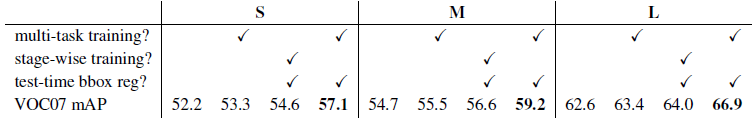
我们观察到多任务训练相对于单独的分类训练提高了纯分类准确度.最后，我们采用baseline模型（仅使用分类损失进行训练），加上bounding-box回归层，并使用Lloc训练它们，同时保持所有其他网络参数冻结。每组中的第三列显示了这种逐级训练方案的结果：mAP相对于第一列有改进，但逐级训练表现不如多任务训练（每组第四列）。

### 尺度不变性：暴力或精细？

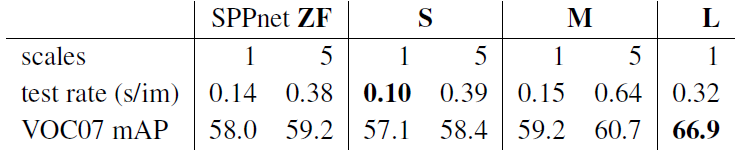
- 所有单尺度实验使用$s=600$像素.
- 在多尺度模型配置中，我们使用指定的相同的五个尺度（$s∈{480,576,688,864,1200}$）
- 具有**单尺度的较大网络**具有最佳的速度/精度平衡

### 我们需要更多训练数据吗？

扩大训练集将提升mAP.

### SVM分类是否优于Softmax？

<img src="../images/ObjectDetection/3-12.png" width=500>

### 更多的候选区域更好吗？

<img src="../images/ObjectDetection/3-13.png" width=500>
观察Sel.Search (SS)这条线,可以观察到发现随着候选区域数量的增加，mAP先上升然后略微下降（如图蓝色实线所示）。这个实验表明，深度神经网络分类器使用更多的候选区域没有帮助，甚至稍微有点影响准确性。

### MS COCO初步结果

PASCAL形式的mAP为35.9％；新的COCO标准下的AP为19.7％

## 结论

本文提出`Fast R-CNN`，一个对`R-CNN`和`SPPnet`更新的简洁、快速版本。除了报告目前最先进的检测结果之外，我们还提供了详细的实验，希望提供新的思路。特别值得注意的是，稀疏目标候选区域似乎提高了检测器的质量。过去这个问题代价太大（在时间上）而一直无法深入探索，但`Fast R-CNN`使其变得可能。当然，可能存在未发现的技术，使得密集框能够达到与稀疏候选框类似的效果。如果这样的方法被开发出来，则可以帮助进一步加速目标检测。

> create:Apotosome 11/06/22

> update:Apotosome 11/13/22